In [1]:
conda install -c conda-forge jaxlib jax

Retrieving notices: ...working... done
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=25.1.1



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt, matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

In [3]:
warnings.filterwarnings('ignore')

NameError: name 'warnings' is not defined

In [4]:
path = "/Users/keitasakurai/PycharmProjects/CDB/blood_cell_images"
print(os.listdir(path))

['basophil', '.DS_Store', 'monocyte', 'erythroblast', 'seg_neutrophil', 'myeloblast']


(363, 360, 3)


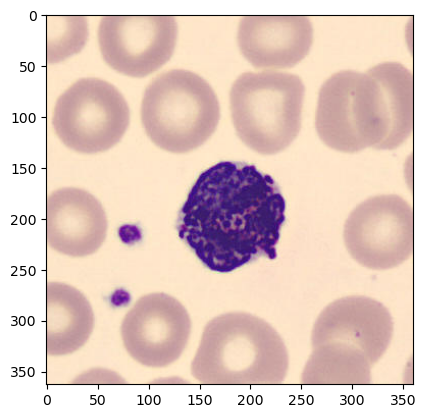

In [5]:
image_path = os.path.join(path, "basophil", "BA_100102.jpg")

try:
    img = mpimg.imread(image_path)
    plt.imshow(img)
    print(img.shape)
    plt.show()

except FileNotFoundError:
    print(f"Image file not found at: {image_path}")
    print("List of files in the basophil directory:")
    !ls basophil

In [6]:
data = []
directories = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

for directory in directories:
    directory_path = os.path.join(path, directory)
    for filename in os.listdir(directory_path):
        if filename.endswith(('.jpg')):
            image_path = os.path.join(directory_path, filename)
            data.append({'Image': image_path, 'Target': directory})

df = pd.DataFrame(data)
print(df.shape)

(5000, 2)


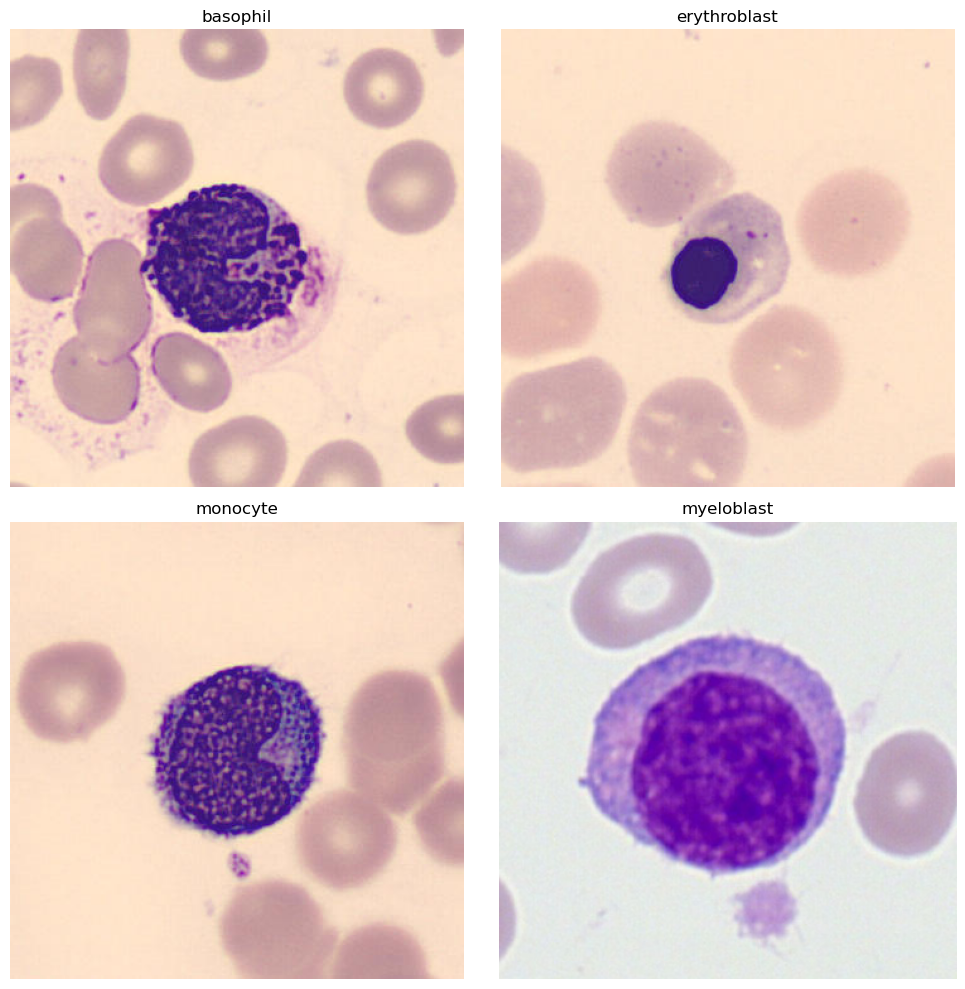

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

unique_targets = df['Target'].unique()
num_unique_targets = len(unique_targets)

for i in range(min(4, num_unique_targets)):
    target = unique_targets[i]
    image_path = df[df['Target'] == target]['Image'].iloc[0]
    try:
        img = mpimg.imread(image_path)
        axes[i].imshow(img)
        axes[i].set_title(target)
        axes[i].axis('off')  # Hide axis ticks and labels
    except FileNotFoundError:
        print(f"Image file not found at: {image_path}")
        axes[i].set_title(f"Image not found for {target}")

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()
plt.show()

In [8]:
dfs = {}
# Iterate through unique targets
for target in df['Target'].unique():
    # Filter DataFrame for the current target
    df_target = df[df['Target'] == target]
    # Split into train, validation, and test sets
    train_df, temp_df = train_test_split(df_target, train_size=700, random_state=42, shuffle=True)
    val_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=42, shuffle=True)

    # Store the DataFrames in the dictionary
    dfs[target] = {'train': train_df, 'val': val_df, 'test': test_df}

train_df = pd.concat([dfs[target]['train'] for target in dfs])
val_df = pd.concat([dfs[target]['val'] for target in dfs])
test_df = pd.concat([dfs[target]['test'] for target in dfs])

# Print the shapes of the resulting DataFrames
print("Train DataFrame shape:", train_df.shape)
print("Validation DataFrame shape:", val_df.shape)
print("Test DataFrame shape:", test_df.shape)

Train DataFrame shape: (3500, 2)
Validation DataFrame shape: (750, 2)
Test DataFrame shape: (750, 2)


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)


train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image",
    y_col="Target",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="Image",
    y_col="Target",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image",
    y_col="Target",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
)

2025-03-24 14:23:07.005304: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 3500 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 5 classes.


(128, 128, 1)


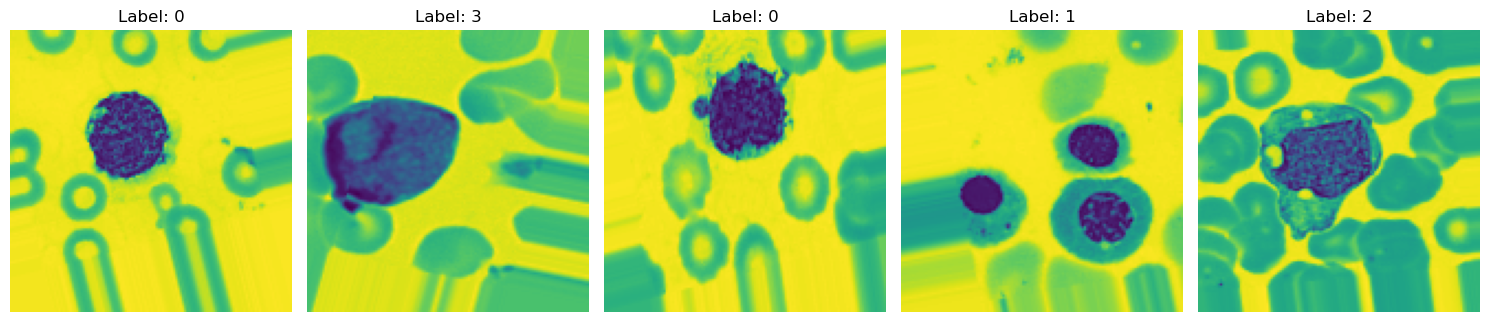

In [10]:
# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Number of images to display
num_images = min(len(images), 5)

# Create a figure and subplots
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Iterate over the images and display them
for i in range(num_images):
    axes[i].imshow(images[i])
    axes[i].set_title(f"Label: {labels[i].argmax()}") # Display predicted class
    axes[i].axis('off')

print(images[0].shape)
plt.tight_layout()
plt.show()

In [11]:
def create_model(input_shape=(128, 128, 1)):
    """
    Create a CNN model with fixed architecture

    Args:
        input_shape: Shape of input images, default (128, 128, 1)

    Returns:
        Compiled Keras model
    """
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Flatten and dense layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_model(model, train_generator, val_generator, epochs=30):
    """
    Train the model with early stopping and learning rate reduction

    Args:
        model: Compiled Keras model
        train_generator: Training data generator
        val_generator: Validation data generator
        epochs: Maximum number of epochs to train

    Returns:
        Training history and trained model
    """
    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        )
    ]

    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )

    return history, model

def plot_training_history(history):
    """
    Plot training history including accuracy and loss curves

    Args:
        history: Keras training history object
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred):
    """
    Plot confusion matrix with class labels

    Args:
        y_true: True labels
        y_pred: Predicted labels
    """
    # Define class labels
    class_labels = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
def print_classification_metrics(y_true, y_pred):
    """
    Print classification report with class labels

    Args:
        y_true: True labels
        y_pred: Predicted labels
    """
    class_labels = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

    report = classification_report(
        y_true,
        y_pred,
        target_names=class_labels,
        digits=4
    )
    print("\nClassification Report:")
    print(report)

def evaluate_model(model, test_generator):
    """
    Evaluate the model on test data

    Args:
        model: Trained Keras model
        test_generator: Test data generator

    Returns:
        Test loss, accuracy, and predicted classes
    """
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

    # Get predictions
    predictions = model.predict(test_generator)
    predicted_classes = predictions.argmax(axis=1)

    return test_loss, test_accuracy, predicted_classes

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [13]:
tf.random.set_seed(42)
np.random.seed(42)

# Define parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 30

# Create and compile model
print("Creating model...")
model = create_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
model.summary()

# Train model
print("\nTraining model...")
history, trained_model = train_model(
    model,
    train_generator,
    val_generator,
    epochs=EPOCHS
)

# Evaluate model
print("\nEvaluating model...")
test_loss, test_accuracy, predictions = evaluate_model(trained_model, test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')

Creating model...


2025-03-24 14:23:46.664970: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-24 14:23:46.665123: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       256       
 hNormalization)                                                 
                                                        

2025-03-24 14:23:47.147691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-03-24 14:23:47.703443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-24 14:23:47.778588: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


110/110 [==============================] - ETA: 0s - loss: 0.9625 - accuracy: 0.7080

2025-03-24 14:23:55.932867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-03-24 14:23:55.999814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - 10s 84ms/step - loss: 0.9625 - accuracy: 0.7080 - val_loss: 8.3820 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/30
110/110 [==============================] - 9s 85ms/step - loss: 0.3614 - accuracy: 0.8766 - val_loss: 11.1303 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
110/110 [==============================] - 10s 86ms/step - loss: 0.2550 - accuracy: 0.9157 - val_loss: 10.2360 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 4/30
110/110 [==============================] - 9s 85ms/step - loss: 0.2483 - accuracy: 0.9206 - val_loss: 9.8095 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 5/30
110/110 [==============================] - 9s 81ms/step - loss: 0.1907 - accuracy: 0.9391 - val_loss: 4.6581 - val_accuracy: 0.2120 - lr: 2.0000e-04
Epoch 6/30
110/110 [==============================] - 9s 80ms/step - loss: 0.1536 - accuracy: 0.9500 - val_loss: 1.4343 - val_accuracy: 0.5427 - lr: 2.0000e-04
Epoch 7/30
110/110 [==============================] - 10s 93ms/

2025-03-24 14:28:01.618304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/24 [>.............................] - ETA: 3s

2025-03-24 14:28:03.289795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-03-24 14:28:03.354830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 2s 59ms/step
Test accuracy: 0.9880


In [ ]:
# Plot results
print("\nPlotting results...")
plot_training_history(history)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Get true labels from test generator
y_true = test_generator.classes

# Plot confusion matrix
plot_confusion_matrix(y_true, predictions)
print_classification_metrics(y_true, predictions)

In [ ]:
import random

In [ ]:
def show_random_predictions(model, test_generator):
    """
    Display 3x3 grid of random test images with predictions.
    """
    # Labels for our classes
    labels = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']
    
    # Create 3x3 subplot
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    
    for i in range(3):
        for j in range(3):
            # Get a random batch and image from test generator
            batch_x, batch_y = next(test_generator)  
            idx = random.randint(0, len(batch_x)-1)
            img = batch_x[idx]
            true_label = np.argmax(batch_y[idx])
            
            # Get prediction
            pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
            pred_label = np.argmax(pred)
            
            # Determine text color (Green if correct, Red if wrong)
            color = 'green' if true_label == pred_label else 'red'
            
            # Plot image
            axes[i, j].imshow(np.squeeze(img), cmap='gray')
            axes[i, j].set_title(
                f'True: {labels[true_label]}\nPred: {labels[pred_label]}',
                color=color, fontsize=12, fontweight='bold'
            )
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Use it with your model:
show_random_predictions(trained_model, test_generator)